# 1. Load Libraries and Datasets

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score


customers_df = pd.read_csv("Customers.csv")
products_df = pd.read_csv("Products.csv")
transactions_df = pd.read_csv("Transactions.csv")

# Display first few rows of each dataset
customers_df.head(), products_df.head(), transactions_df.head()


(  CustomerID        CustomerName         Region  SignupDate
 0      C0001    Lawrence Carroll  South America  2022-07-10
 1      C0002      Elizabeth Lutz           Asia  2022-02-13
 2      C0003      Michael Rivera  South America  2024-03-07
 3      C0004  Kathleen Rodriguez  South America  2022-10-09
 4      C0005         Laura Weber           Asia  2022-08-15,
   ProductID              ProductName     Category   Price
 0      P001     ActiveWear Biography        Books  169.30
 1      P002    ActiveWear Smartwatch  Electronics  346.30
 2      P003  ComfortLiving Biography        Books   44.12
 3      P004            BookWorld Rug   Home Decor   95.69
 4      P005          TechPro T-Shirt     Clothing  429.31,
   TransactionID CustomerID ProductID      TransactionDate  Quantity  \
 0        T00001      C0199      P067  2024-08-25 12:38:23         1   
 1        T00112      C0146      P067  2024-05-27 22:23:54         1   
 2        T00166      C0127      P067  2024-04-25 07:38:55    

In [4]:

customers_df.info()
products_df.info()
transactions_df.info()


print("Missing Values in Customers:\n", customers_df.isnull().sum())
print("Missing Values in Products:\n", products_df.isnull().sum())
print("Missing Values in Transactions:\n", transactions_df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  


# 3. Exploratory Data Analysis (EDA)


## 3.1 Customer Distribution by Region



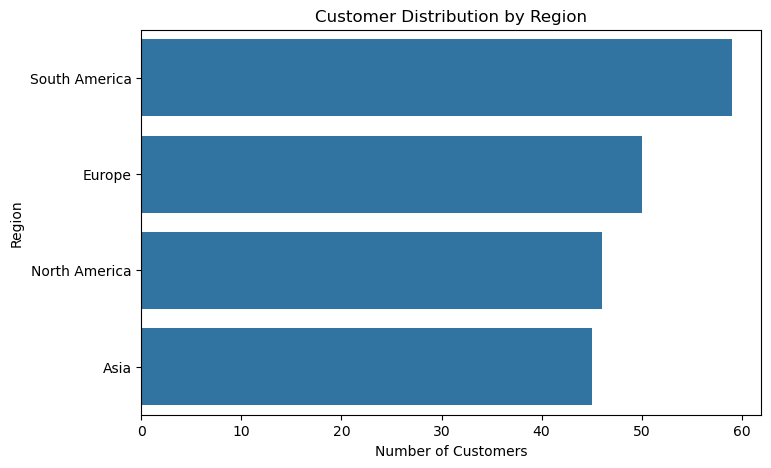

In [11]:

customers_df["SignupDate"] = pd.to_datetime(customers_df["SignupDate"])
transactions_df["TransactionDate"] = pd.to_datetime(transactions_df["TransactionDate"])


plt.figure(figsize=(8,5))
sns.countplot(y=customers_df["Region"], order=customers_df["Region"].value_counts().index)
plt.title("Customer Distribution by Region")
plt.xlabel("Number of Customers")
plt.ylabel("Region")
plt.show()


## 3.2 Monthly Sales Trend

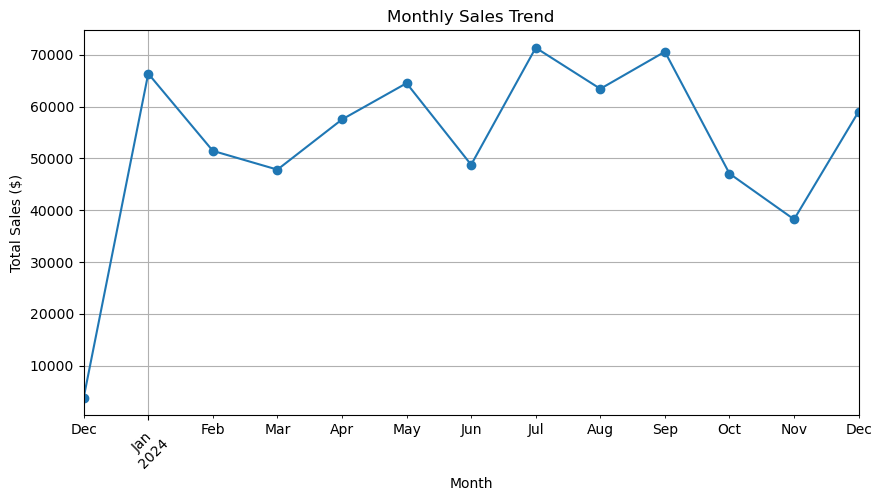

In [14]:
# Aggregate sales data by month
transactions_df["TransactionMonth"] = transactions_df["TransactionDate"].dt.to_period("M")
monthly_sales = transactions_df.groupby("TransactionMonth")["TotalValue"].sum()

# Plot monthly sales trend
plt.figure(figsize=(10,5))
monthly_sales.plot(marker="o")
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Sales ($)")
plt.xticks(rotation=45)
plt.grid()
plt.show()


## 3.3 Sales by Product Category

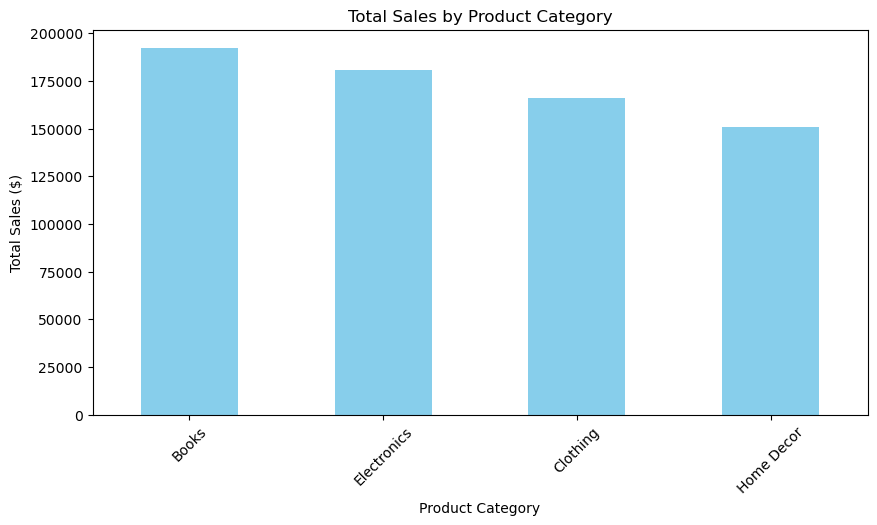

In [17]:
# Merge transactions with product data for category-wise sales analysis
transactions_products = transactions_df.merge(products_df, on="ProductID")
category_sales = transactions_products.groupby("Category")["TotalValue"].sum().sort_values(ascending=False)

# Plot total sales by product category
plt.figure(figsize=(10,5))
category_sales.plot(kind="bar", color="skyblue")
plt.title("Total Sales by Product Category")
plt.xlabel("Product Category")
plt.ylabel("Total Sales ($)")
plt.xticks(rotation=45)
plt.show()


# 4. Lookalike Model




In [20]:
# Encode categorical variables for numerical processing
le_region = LabelEncoder()
customers_df["RegionEncoded"] = le_region.fit_transform(customers_df["Region"])

# Aggregate total spending per customer
customer_spending = transactions_df.groupby("CustomerID")["TotalValue"].sum().reset_index()
customer_spending.columns = ["CustomerID", "TotalSpending"]

# Merge customer data with spending
customer_features = customers_df.merge(customer_spending, on="CustomerID", how="left").fillna(0)

# Select features for similarity computation
feature_cols = ["RegionEncoded", "TotalSpending"]
customer_matrix = customer_features[feature_cols].values

# Compute cosine similarity between customers
similarity_matrix = cosine_similarity(customer_matrix)

# Find top 3 similar customers for the first 20 customers
top_customers = customers_df["CustomerID"].iloc[:20].values
lookalike_results = {}

for idx, cust_id in enumerate(top_customers):
    similar_indices = np.argsort(similarity_matrix[idx])[::-1][1:4]  # Exclude self, take top 3
    similar_customers = [(customers_df["CustomerID"].iloc[i], similarity_matrix[idx][i]) for i in similar_indices]
    lookalike_results[cust_id] = similar_customers

# Convert results into a structured DataFrame
lookalike_df = pd.DataFrame(
    [(cust, sim_cust, score) for cust, sim_list in lookalike_results.items() for sim_cust, score in sim_list],
    columns=["CustomerID", "SimilarCustomerID", "SimilarityScore"]
)

# Save Lookalike Model results
lookalike_df.to_csv("Lookalike.csv", index=False)
lookalike_df.head()


,CustomerID,SimilarCustomerID,SimilarityScore
0,C0001,C0181,1.0
1,C0001,C0137,1.0
2,C0001,C0152,1.0
3,C0002,C0146,1.0
4,C0002,C0173,1.0


# 5. Customer Segmentation using Clustering

## 5.1 Determine Optimal Number of Clusters



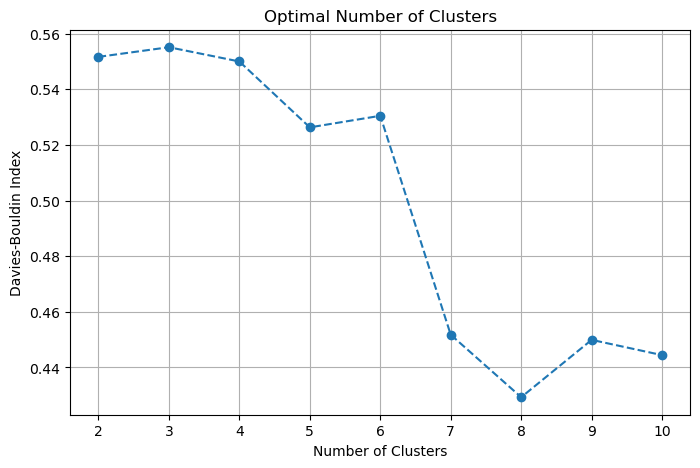

In [26]:
# Compute Davies-Bouldin Index for different cluster sizes
db_scores = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(customer_matrix)
    db_score = davies_bouldin_score(customer_matrix, labels)
    db_scores.append(db_score)

# Plot DB Index values
plt.figure(figsize=(8,5))
plt.plot(cluster_range, db_scores, marker='o', linestyle='dashed')
plt.xlabel("Number of Clusters")
plt.ylabel("Davies-Bouldin Index")
plt.title("Optimal Number of Clusters")
plt.grid()
plt.show()


## 5.2 Perform Clustering

In [29]:
# Select optimal cluster count
optimal_k = cluster_range[np.argmin(db_scores)]
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customers_df["Cluster"] = kmeans_final.fit_predict(customer_matrix)

# Store clustering results
clustering_results = customers_df[["CustomerID", "Cluster"]]
clustering_results.to_csv("Customer_Segmentation.csv", index=False)

# Display first few rows
clustering_results.head()


,CustomerID,Cluster
0,C0001,2
1,C0002,5
2,C0003,2
3,C0004,1
4,C0005,5
